In [1]:
from tqdm.auto import tqdm
import time

# Test progress bar
for i in tqdm(range(10), desc="Testing progress bar"):
    time.sleep(0.1)

print("✅ Progress bar test complete!")


Testing progress bar:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Progress bar test complete!


In [2]:
# ============================================================================
# FORCE CLEAN IMPORT - MUST RUN THIS FIRST
# ============================================================================
import sys
import os

# Remove ALL cached utils modules
for key in list(sys.modules.keys()):
    if 'utils' in key:
        del sys.modules[key]

# Ensure correct path
sys.path.insert(0, '/workspaces/Alzheimer-s-Biomarker/tau_stacking_project')

# Test imports
try:
    from utils.config import SEQUENCES_CSV
    print(f"✅ SEQUENCES_CSV imported: {SEQUENCES_CSV}")
except ImportError as e:
    print(f"❌ Error: {e}")


✅ SEQUENCES_CSV imported: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/sequences.csv


In [3]:
"""
Preprocessing for Tau Protein Misfolding Prediction

This notebook:
1. Loads processed sequences and labels
2. Creates train/val/test splits
3. Generates ProtBERT embeddings
4. Creates integer-encoded sequences
5. Saves all preprocessed data
"""
# ============================================================================
# FORCE CLEAN MODULE RELOAD - RUN THIS CELL FIRST
# ============================================================================
import sys
import os

# Clear ALL cached utils modules
modules_to_remove = [key for key in list(sys.modules.keys()) if 'utils' in key]
for key in modules_to_remove:
    del sys.modules[key]

print(f"✅ Cleared {len(modules_to_remove)} cached modules")

# Ensure project is in path
project_path = '/workspaces/Alzheimer-s-Biomarker/tau_stacking_project'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

print(f"✅ Working from: {os.getcwd()}")
print(f"✅ Python path includes: {project_path}")

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
from tqdm.notebook import tqdm

# Import our utilities
from utils import (
    load_core_tables,
    make_splits,
    save_core_tables,
    compute_protbert_embeddings,
    encode_sequences_to_int,
    create_attention_masks,
    compute_sequence_features,
    save_embeddings_and_arrays,
    SEQUENCES_CSV,
    LABELS_CSV,
    SPLITS_CSV,
    EMBEDDINGS_DIR,
    AMINO_ACID_VOCAB,
    DEVICE,
    TRAIN_RATIO,
    VAL_RATIO,
    TEST_RATIO,
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Imports successful!")
print(f"Device: {DEVICE}")
print(f"Working directory: {Path.cwd()}")


✅ Cleared 347 cached modules
✅ Working from: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/notebooks
✅ Python path includes: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project
✅ Imports successful!
Device: cpu
Working directory: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/notebooks


In [4]:
"""
Load sequences and labels from previous notebook
"""

print("=" * 80)
print("STEP 1: LOADING PROCESSED DATA")
print("=" * 80)

# Load sequences and labels
df_sequences = pd.read_csv(SEQUENCES_CSV)
df_labels = pd.read_csv(LABELS_CSV)

print(f"✅ Loaded sequences: {len(df_sequences)} samples")
print(f"✅ Loaded labels: {len(df_labels)} samples")

# Merge
df_data = df_sequences.merge(df_labels, on='protein_id')

print(f"\n📊 Merged dataset:")
print(f"  Total samples: {len(df_data)}")
print(f"  Features: {df_data.columns.tolist()}")

# Display first few rows
print("\n📋 First 5 rows:")
print(df_data.head())

# Check data types
print("\n🔍 Data types:")
print(df_data.dtypes)

# Check for duplicates
n_duplicates = df_data['protein_id'].duplicated().sum()
print(f"\n🔍 Duplicate protein IDs: {n_duplicates}")


STEP 1: LOADING PROCESSED DATA
✅ Loaded sequences: 203 samples
✅ Loaded labels: 203 samples

📊 Merged dataset:
  Total samples: 203
  Features: ['protein_id', 'description', 'sequence', 'length', 'species', 'label', 'source']

📋 First 5 rows:
   protein_id                                        description  \
0  A0A0N7CSQ4  sp|A0A0N7CSQ4|TX41A_SCOMU Tau-scoloptoxin(04)-...   
1  A0A5F8MPU3  sp|A0A5F8MPU3|CTSRT_MOUSE Cation channel sperm...   
2      O02828  sp|O02828|TAU_CAPHI Microtubule-associated pro...   
3      P06710  sp|P06710|DPO3X_ECOLI DNA polymerase III subun...   
4      P10636  sp|P10636|TAU_HUMAN Microtubule-associated pro...   

                                            sequence  length  \
0  MLKSFCILSVFMVLFLAKFPDLCSGEEISPLKIVVRNSEYLNNPCN...      68   
1  MELPPPGNRRVSINNPQETSGRVPTTSAGFPTQSSKISLKRSTYAY...    2282   
2  MAEPRQEFDVMEDHAQGDYTLQDHEGDMEPGLKESPLQTPADDGSE...     403   
3  MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...     643   
4  MAEPRQEFEVMEDHAGTYGLGDRKD

2025-12-18 08:36:24,643 - utils.dataset - INFO - Creating splits: train=0.7, val=0.15, test=0.15


STEP 2: CREATING DATA SPLITS
Split ratios:
  Train: 70%
  Val:   15%
  Test:  15%


2025-12-18 08:36:24,667 - utils.dataset - INFO - Split statistics:
2025-12-18 08:36:24,670 - utils.dataset - INFO -   train: 141 samples
2025-12-18 08:36:24,679 - utils.dataset - INFO -     Label distribution: {0: 99, 1: 42}
2025-12-18 08:36:24,680 - utils.dataset - INFO -   val: 31 samples
2025-12-18 08:36:24,690 - utils.dataset - INFO -     Label distribution: {0: 22, 1: 9}
2025-12-18 08:36:24,691 - utils.dataset - INFO -   test: 31 samples
2025-12-18 08:36:24,695 - utils.dataset - INFO -     Label distribution: {0: 22, 1: 9}



📊 Split statistics:

TRAIN:
  Total: 141
  Label 0 (Normal): 99 (70.2%)
  Label 1 (Misfolding): 42 (29.8%)

VAL:
  Total: 31
  Label 0 (Normal): 22 (71.0%)
  Label 1 (Misfolding): 9 (29.0%)

TEST:
  Total: 31
  Label 0 (Normal): 22 (71.0%)
  Label 1 (Misfolding): 9 (29.0%)


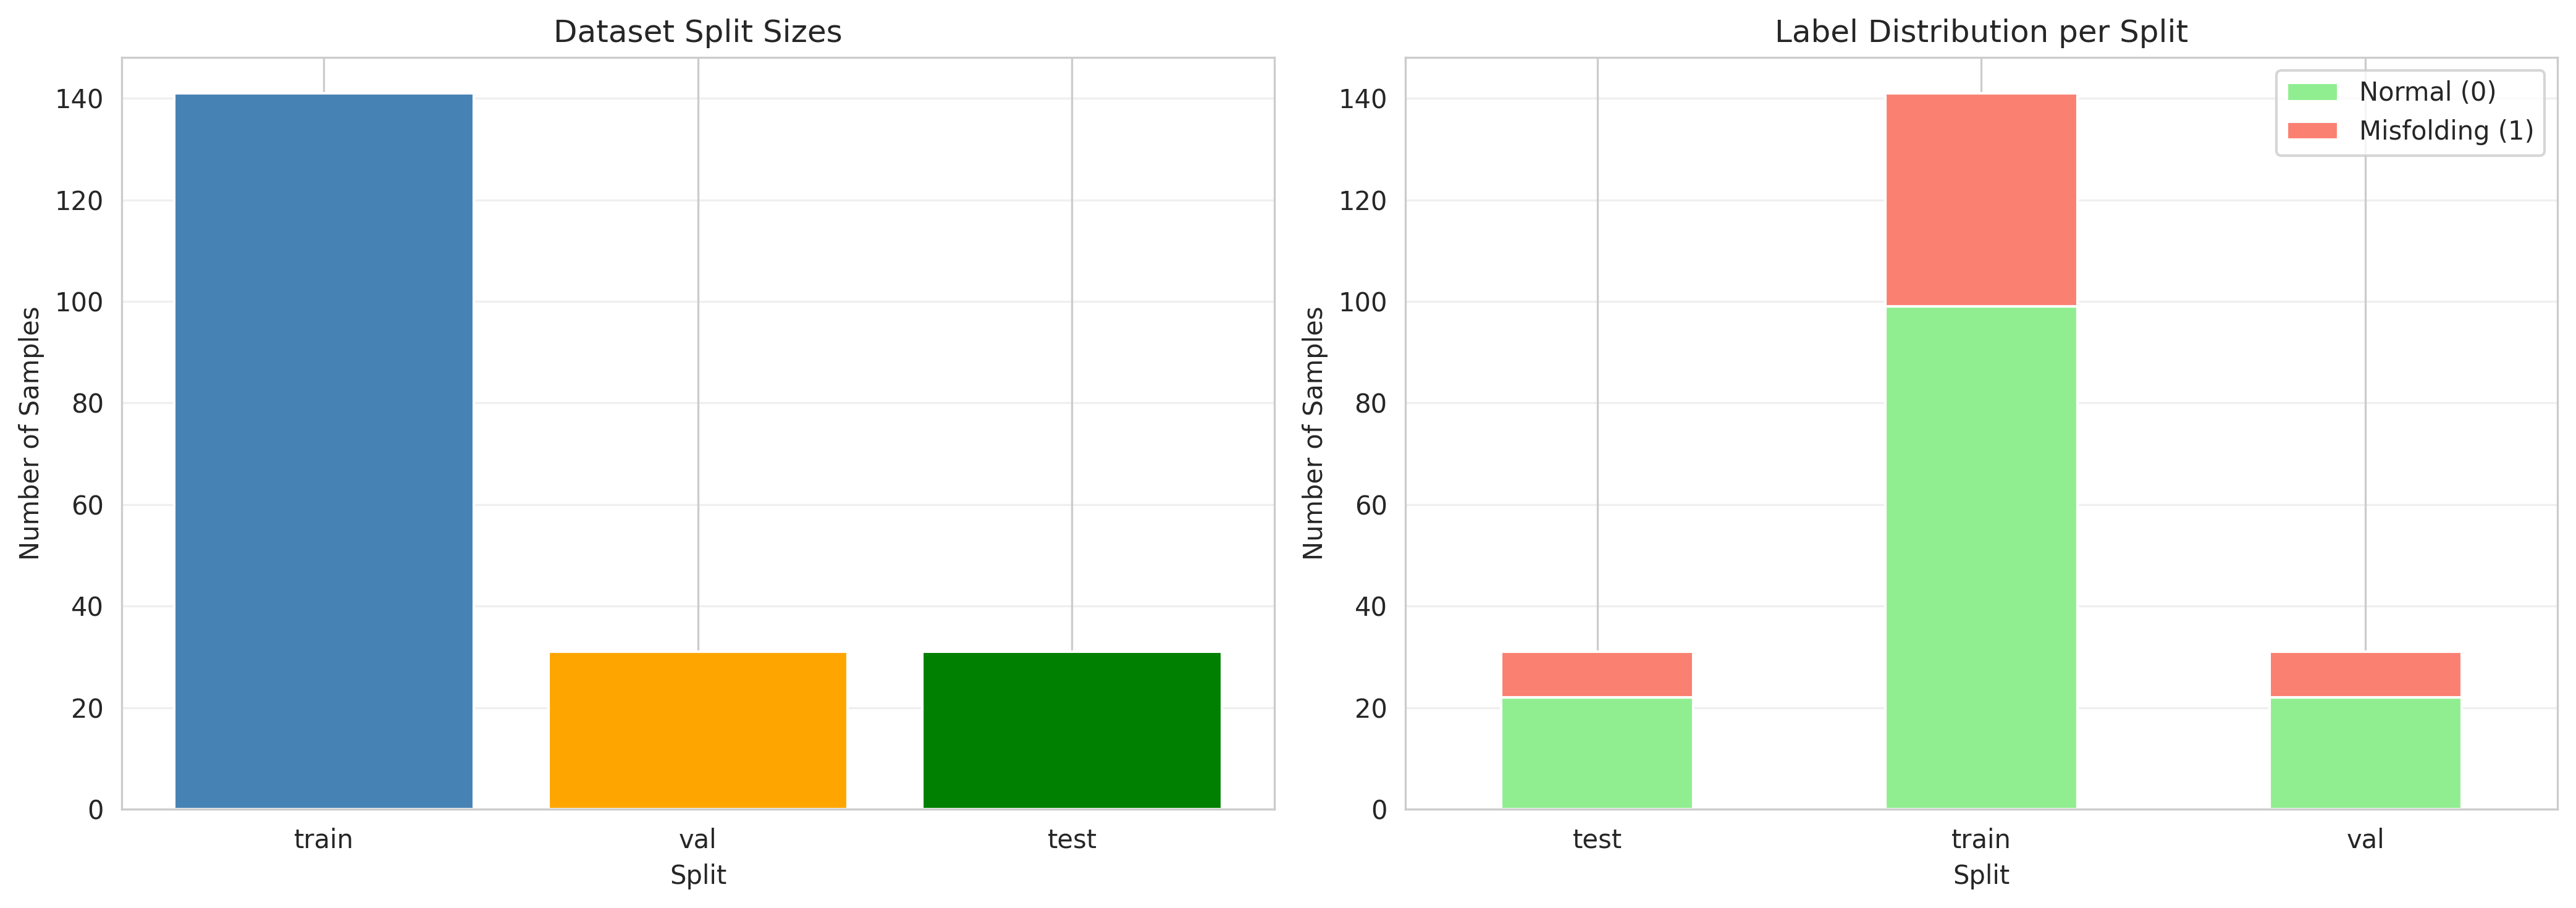

2025-12-18 08:36:25,223 - utils.dataset - INFO - Saving core tables...
2025-12-18 08:36:25,236 - utils.dataset - INFO - Saved sequences: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/sequences.csv
2025-12-18 08:36:25,239 - utils.dataset - INFO - Saved labels: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/labels.csv
2025-12-18 08:36:25,241 - utils.dataset - INFO - Saved splits: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/splits.csv
2025-12-18 08:36:25,242 - utils.dataset - INFO - All core tables saved successfully



✅ Saved splits to: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/splits.csv


In [5]:
"""
Create stratified train/validation/test splits
"""

print("=" * 80)
print("STEP 2: CREATING DATA SPLITS")
print("=" * 80)

print(f"Split ratios:")
print(f"  Train: {TRAIN_RATIO*100:.0f}%")
print(f"  Val:   {VAL_RATIO*100:.0f}%")
print(f"  Test:  {TEST_RATIO*100:.0f}%")

# Create splits with stratification on labels
df_with_splits = make_splits(
    df_data,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    stratify_column='label'
)

# Display split statistics
print(f"\n📊 Split statistics:")
for split_name in ['train', 'val', 'test']:
    split_data = df_with_splits[df_with_splits['split'] == split_name]
    n_samples = len(split_data)
    n_positive = (split_data['label'] == 1).sum()
    n_negative = (split_data['label'] == 0).sum()
    
    print(f"\n{split_name.upper()}:")
    print(f"  Total: {n_samples}")
    print(f"  Label 0 (Normal): {n_negative} ({n_negative/n_samples*100:.1f}%)")
    print(f"  Label 1 (Misfolding): {n_positive} ({n_positive/n_samples*100:.1f}%)")

# Visualize splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Split sizes
split_counts = df_with_splits['split'].value_counts()
axes[0].bar(split_counts.index, split_counts.values, color=['steelblue', 'orange', 'green'])
axes[0].set_xlabel('Split')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Dataset Split Sizes')
axes[0].grid(alpha=0.3, axis='y')

# Label distribution per split
split_label_counts = df_with_splits.groupby(['split', 'label']).size().unstack()
split_label_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['lightgreen', 'salmon'])
axes[1].set_xlabel('Split')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Label Distribution per Split')
axes[1].legend(['Normal (0)', 'Misfolding (1)'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Save splits
save_core_tables(
    df_sequences=df_with_splits[['protein_id', 'description', 'sequence', 'length', 'species']],
    df_labels=df_with_splits[['protein_id', 'label', 'source']],
    df_splits=df_with_splits[['protein_id', 'split']]
)

print(f"\n✅ Saved splits to: {SPLITS_CSV}")


2025-12-18 08:36:25,369 - utils.preprocessing - INFO - Generating ProtBERT embeddings for 141 sequences
2025-12-18 08:36:25,370 - utils.preprocessing - INFO - Using device: cpu
2025-12-18 08:36:25,375 - utils.preprocessing - INFO - Loading model: Rostlab/prot_bert


STEP 3: GENERATING PROTBERT EMBEDDINGS (TRAIN)
🔬 Generating embeddings for 141 training sequences...
⏱️  This may take 10-30 minutes...
💻 Using device: cpu


Generating embeddings: 100%|██████████| 18/18 [11:51<00:00, 39.51s/it]
2025-12-18 08:48:34,430 - utils.preprocessing - INFO - Generated embeddings shape: (141, 1024)
2025-12-18 08:48:34,449 - utils.preprocessing - INFO - Saved embeddings to cache: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/results/embeddings/protbert_train.npy



✅ Training embeddings generated!
   Shape: (141, 1024)
   Embedding dimension: 1024
   Memory: 0.6 MB


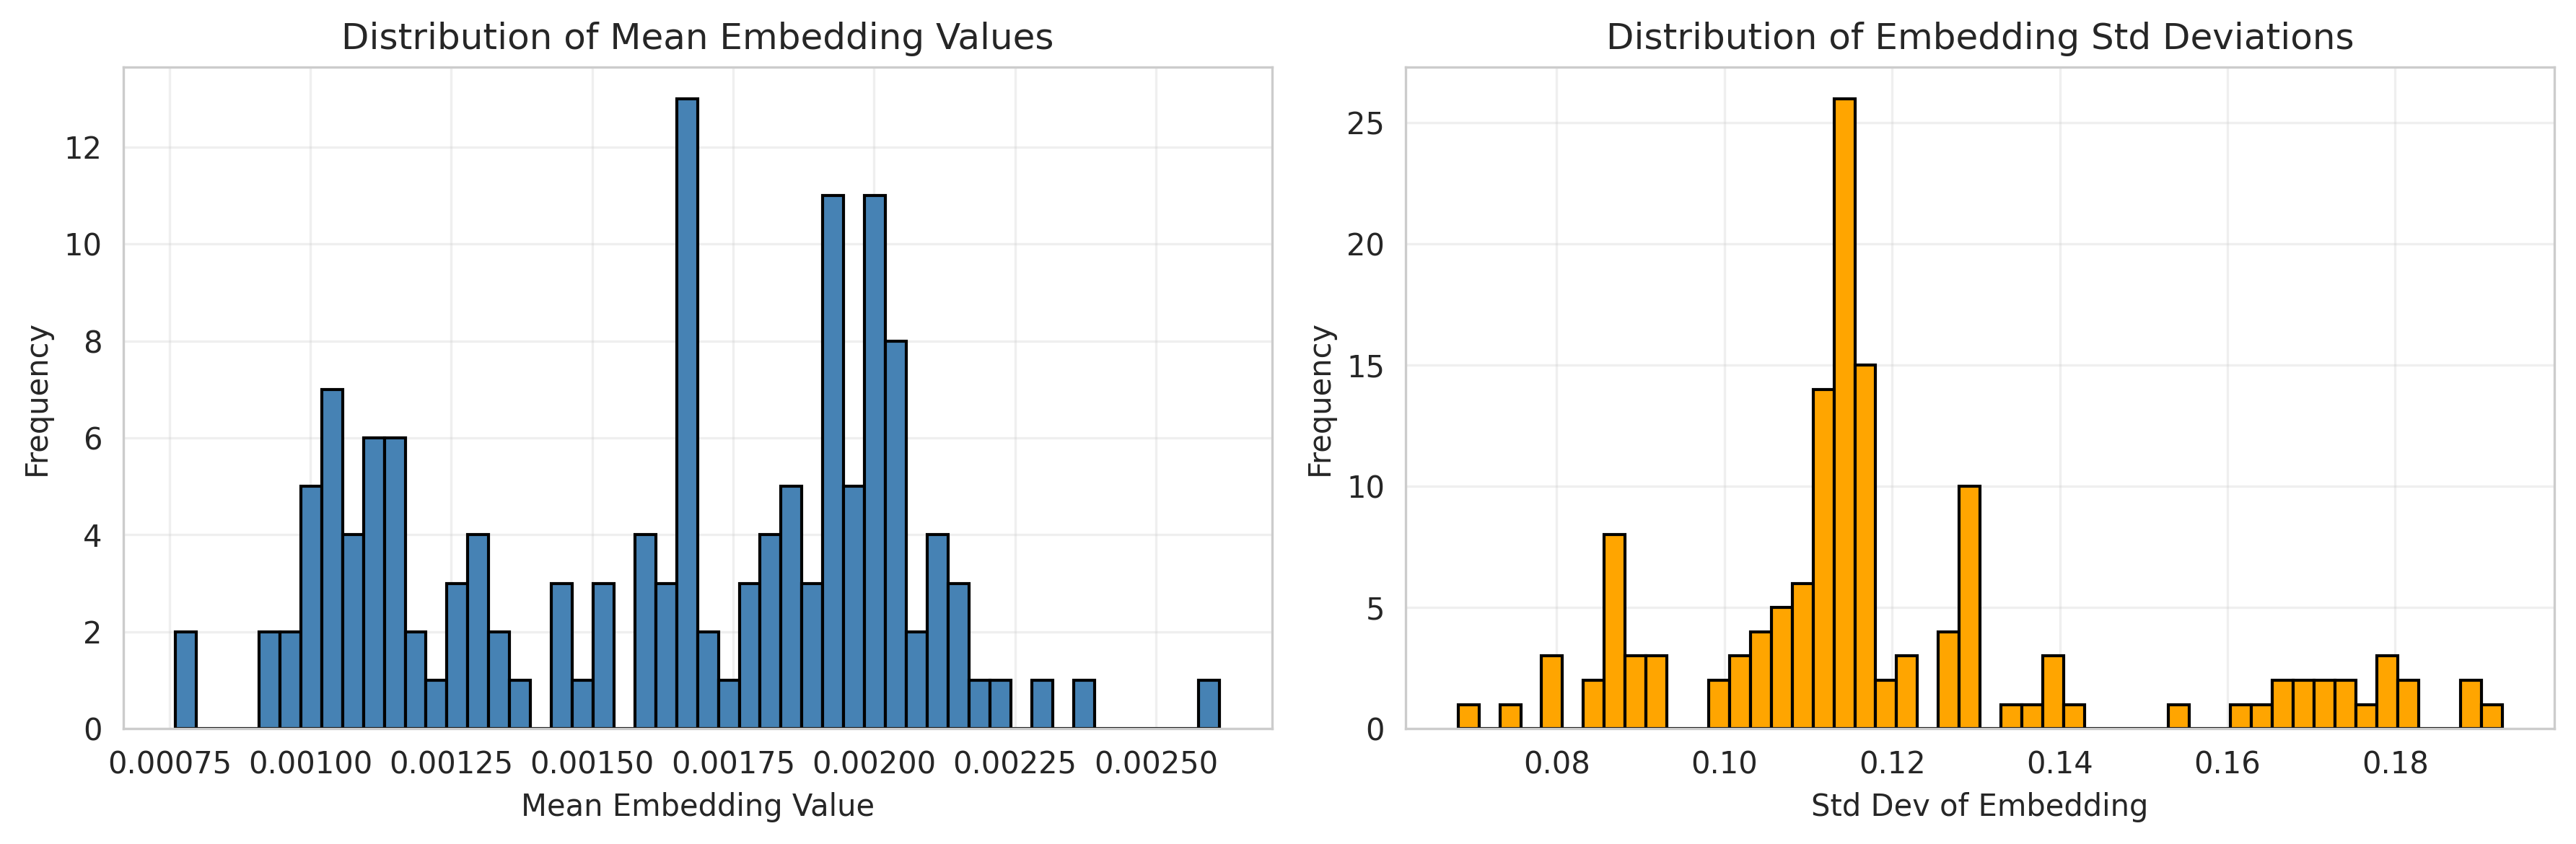

In [6]:
"""
Generate ProtBERT embeddings for TRAINING set
This may take 10-30 minutes depending on dataset size and device
"""

print("=" * 80)
print("STEP 3: GENERATING PROTBERT EMBEDDINGS (TRAIN)")
print("=" * 80)

# Get training sequences
train_data = df_with_splits[df_with_splits['split'] == 'train']
train_sequences = train_data['sequence'].tolist()

print(f"🔬 Generating embeddings for {len(train_sequences)} training sequences...")
print(f"⏱️  This may take 10-30 minutes...")
print(f"💻 Using device: {DEVICE}")

# Generate embeddings
cache_path = EMBEDDINGS_DIR / "protbert_train.npy"

train_embeddings = compute_protbert_embeddings(
    sequences=train_sequences,
    batch_size=8,  # Adjust based on your GPU memory
    pooling='mean',
    device=DEVICE,
    cache_path=cache_path,
    use_cache=True  # Will load from cache if exists
)

print(f"\n✅ Training embeddings generated!")
print(f"   Shape: {train_embeddings.shape}")
print(f"   Embedding dimension: {train_embeddings.shape[1]}")
print(f"   Memory: {train_embeddings.nbytes / 1024**2:.1f} MB")

# Visualize embedding statistics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_embeddings.mean(axis=1), bins=50, color='steelblue', edgecolor='black')
plt.xlabel('Mean Embedding Value')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Embedding Values')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_embeddings.std(axis=1), bins=50, color='orange', edgecolor='black')
plt.xlabel('Std Dev of Embedding')
plt.ylabel('Frequency')
plt.title('Distribution of Embedding Std Deviations')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
"""
Generate ProtBERT embeddings for VALIDATION and TEST sets
"""

print("=" * 80)
print("STEP 4: GENERATING PROTBERT EMBEDDINGS (VAL & TEST)")
print("=" * 80)

# Validation set
print("\n🔬 Generating VALIDATION embeddings...")
val_data = df_with_splits[df_with_splits['split'] == 'val']
val_sequences = val_data['sequence'].tolist()
cache_path_val = EMBEDDINGS_DIR / "protbert_val.npy"

val_embeddings = compute_protbert_embeddings(
    sequences=val_sequences,
    batch_size=8,
    pooling='mean',
    device=DEVICE,
    cache_path=cache_path_val,
    use_cache=True
)

print(f"✅ Validation embeddings: {val_embeddings.shape}")

# Test set
print("\n🔬 Generating TEST embeddings...")
test_data = df_with_splits[df_with_splits['split'] == 'test']
test_sequences = test_data['sequence'].tolist()
cache_path_test = EMBEDDINGS_DIR / "protbert_test.npy"

test_embeddings = compute_protbert_embeddings(
    sequences=test_sequences,
    batch_size=8,
    pooling='mean',
    device=DEVICE,
    cache_path=cache_path_test,
    use_cache=True
)

print(f"✅ Test embeddings: {test_embeddings.shape}")

print(f"\n📊 Embedding Summary:")
print(f"  Train: {train_embeddings.shape}")
print(f"  Val:   {val_embeddings.shape}")
print(f"  Test:  {test_embeddings.shape}")
print(f"  Total memory: {(train_embeddings.nbytes + val_embeddings.nbytes + test_embeddings.nbytes) / 1024**2:.1f} MB")


2025-12-18 08:48:45,753 - utils.preprocessing - INFO - Generating ProtBERT embeddings for 31 sequences
2025-12-18 08:48:45,757 - utils.preprocessing - INFO - Using device: cpu
2025-12-18 08:48:45,759 - utils.preprocessing - INFO - Loading model: Rostlab/prot_bert


STEP 4: GENERATING PROTBERT EMBEDDINGS (VAL & TEST)

🔬 Generating VALIDATION embeddings...


Generating embeddings: 100%|██████████| 4/4 [02:39<00:00, 39.87s/it]
2025-12-18 08:51:41,609 - utils.preprocessing - INFO - Generated embeddings shape: (31, 1024)
2025-12-18 08:51:41,619 - utils.preprocessing - INFO - Saved embeddings to cache: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/results/embeddings/protbert_val.npy
2025-12-18 08:51:41,674 - utils.preprocessing - INFO - Generating ProtBERT embeddings for 31 sequences
2025-12-18 08:51:41,675 - utils.preprocessing - INFO - Using device: cpu
2025-12-18 08:51:41,676 - utils.preprocessing - INFO - Loading model: Rostlab/prot_bert


✅ Validation embeddings: (31, 1024)

🔬 Generating TEST embeddings...


Generating embeddings: 100%|██████████| 4/4 [02:37<00:00, 39.42s/it]
2025-12-18 08:54:34,101 - utils.preprocessing - INFO - Generated embeddings shape: (31, 1024)
2025-12-18 08:54:34,107 - utils.preprocessing - INFO - Saved embeddings to cache: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/results/embeddings/protbert_test.npy


✅ Test embeddings: (31, 1024)

📊 Embedding Summary:
  Train: (141, 1024)
  Val:   (31, 1024)
  Test:  (31, 1024)
  Total memory: 0.8 MB


2025-12-18 08:54:34,337 - utils.preprocessing - INFO - Encoding 141 sequences to integers
2025-12-18 08:54:34,353 - utils.preprocessing - INFO - Encoded shape: (141, 1146)


STEP 5: INTEGER ENCODING
Max sequence length (95th percentile): 1146

🔢 Encoding TRAIN sequences...


2025-12-18 08:54:34,355 - utils.preprocessing - INFO - Encoding 31 sequences to integers
2025-12-18 08:54:34,359 - utils.preprocessing - INFO - Encoded shape: (31, 1146)
2025-12-18 08:54:34,361 - utils.preprocessing - INFO - Encoding 31 sequences to integers
2025-12-18 08:54:34,365 - utils.preprocessing - INFO - Encoded shape: (31, 1146)


✅ Train encoded shape: (141, 1146)

🔢 Encoding VALIDATION sequences...
✅ Val encoded shape: (31, 1146)

🔢 Encoding TEST sequences...
✅ Test encoded shape: (31, 1146)

🎭 Creating attention masks...
✅ Masks created:
  Train: (141, 1146)
  Val:   (31, 1146)
  Test:  (31, 1146)


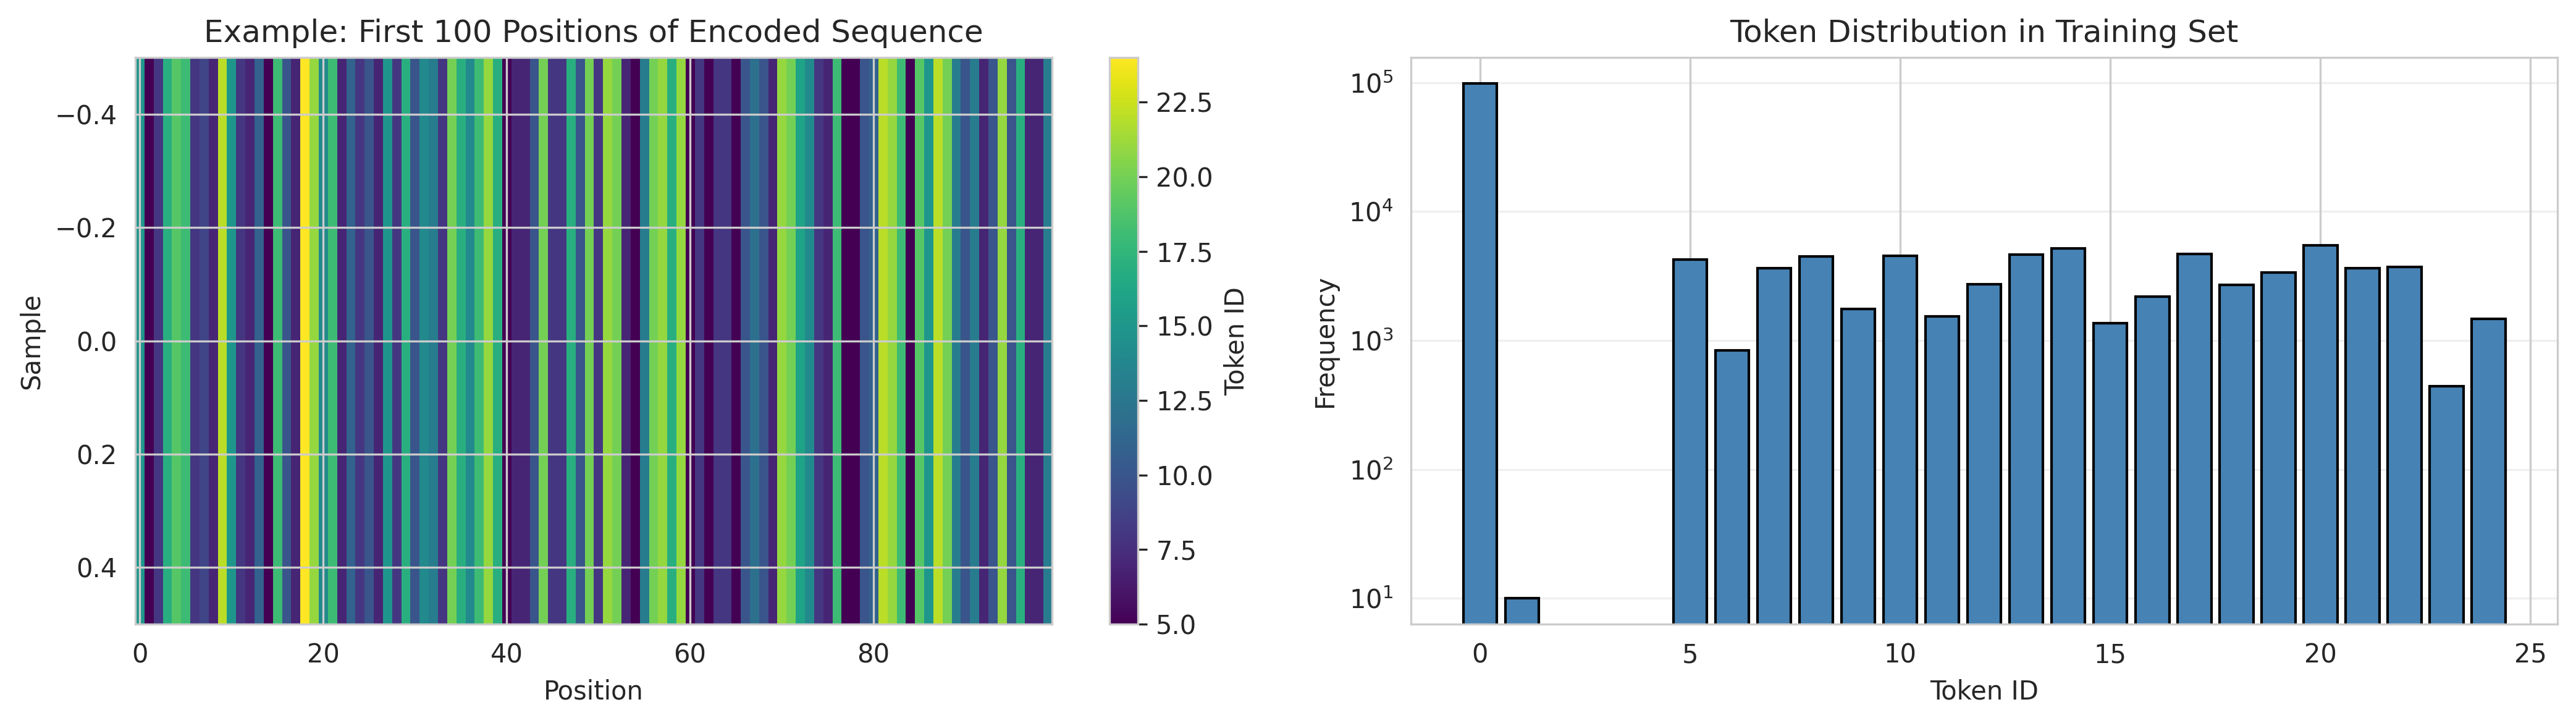

In [8]:
"""
Create integer-encoded sequences for CNN-BiLSTM and Transformer models
"""

print("=" * 80)
print("STEP 5: INTEGER ENCODING")
print("=" * 80)

# Determine max sequence length
all_lengths = df_with_splits['length'].values
max_length = int(np.percentile(all_lengths, 95))  # Use 95th percentile to avoid extreme outliers
print(f"Max sequence length (95th percentile): {max_length}")

# Encode train sequences
print("\n🔢 Encoding TRAIN sequences...")
train_encoded = encode_sequences_to_int(
    sequences=train_sequences,
    vocab=AMINO_ACID_VOCAB,
    max_length=max_length,
    padding='post',
    truncating='post'
)
print(f"✅ Train encoded shape: {train_encoded.shape}")

# Encode validation sequences
print("\n🔢 Encoding VALIDATION sequences...")
val_encoded = encode_sequences_to_int(
    sequences=val_sequences,
    vocab=AMINO_ACID_VOCAB,
    max_length=max_length,
    padding='post',
    truncating='post'
)
print(f"✅ Val encoded shape: {val_encoded.shape}")

# Encode test sequences
print("\n🔢 Encoding TEST sequences...")
test_encoded = encode_sequences_to_int(
    sequences=test_sequences,
    vocab=AMINO_ACID_VOCAB,
    max_length=max_length,
    padding='post',
    truncating='post'
)
print(f"✅ Test encoded shape: {test_encoded.shape}")

# Create attention masks
print("\n🎭 Creating attention masks...")
train_masks = create_attention_masks(train_encoded)
val_masks = create_attention_masks(val_encoded)
test_masks = create_attention_masks(test_encoded)

print(f"✅ Masks created:")
print(f"  Train: {train_masks.shape}")
print(f"  Val:   {val_masks.shape}")
print(f"  Test:  {test_masks.shape}")

# Visualize encoding
plt.figure(figsize=(14, 4))

# Show first sequence encoding
sample_idx = 0
sample_encoded = train_encoded[sample_idx][:100]  # First 100 positions

plt.subplot(1, 2, 1)
plt.imshow(sample_encoded.reshape(1, -1), cmap='viridis', aspect='auto')
plt.colorbar(label='Token ID')
plt.xlabel('Position')
plt.ylabel('Sample')
plt.title('Example: First 100 Positions of Encoded Sequence')

# Token distribution
plt.subplot(1, 2, 2)
unique, counts = np.unique(train_encoded.flatten(), return_counts=True)
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.title('Token Distribution in Training Set')
plt.yscale('log')
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


2025-12-18 08:54:36,660 - utils.preprocessing - INFO - Computing sequence features for 141 sequences


STEP 6: COMPUTING HAND-CRAFTED FEATURES

🔬 Computing features for all sequences...


2025-12-18 08:54:36,734 - utils.preprocessing - INFO - Computed features shape: (141, 5)
2025-12-18 08:54:36,736 - utils.preprocessing - INFO - Computing sequence features for 31 sequences
2025-12-18 08:54:36,745 - utils.preprocessing - INFO - Computed features shape: (31, 5)
2025-12-18 08:54:36,746 - utils.preprocessing - INFO - Computing sequence features for 31 sequences
2025-12-18 08:54:36,750 - utils.preprocessing - INFO - Computed features shape: (31, 5)


✅ Feature shapes:
  Train: (141, 5)
  Val:   (31, 5)
  Test:  (31, 5)

📊 Training set feature statistics:
            length  charged_pct  hydrophobic_pct  aromatic_pct   polar_pct
count   141.000000   141.000000       141.000000    141.000000  141.000000
mean    455.120567    25.673473        34.362428      6.607582   21.300491
std     293.410889     2.786818         6.918978      3.951524    4.455577
min      14.000000    15.304606        24.096386      1.562500    7.142857
25%     243.000000    24.698795        26.442308      2.260638   19.303797
50%     409.000000    25.935162        35.941320      7.179487   22.298851
75%     563.000000    26.655052        40.410959      9.053498   24.934383
max    1820.000000    33.783784        45.922747     20.588235   30.000000


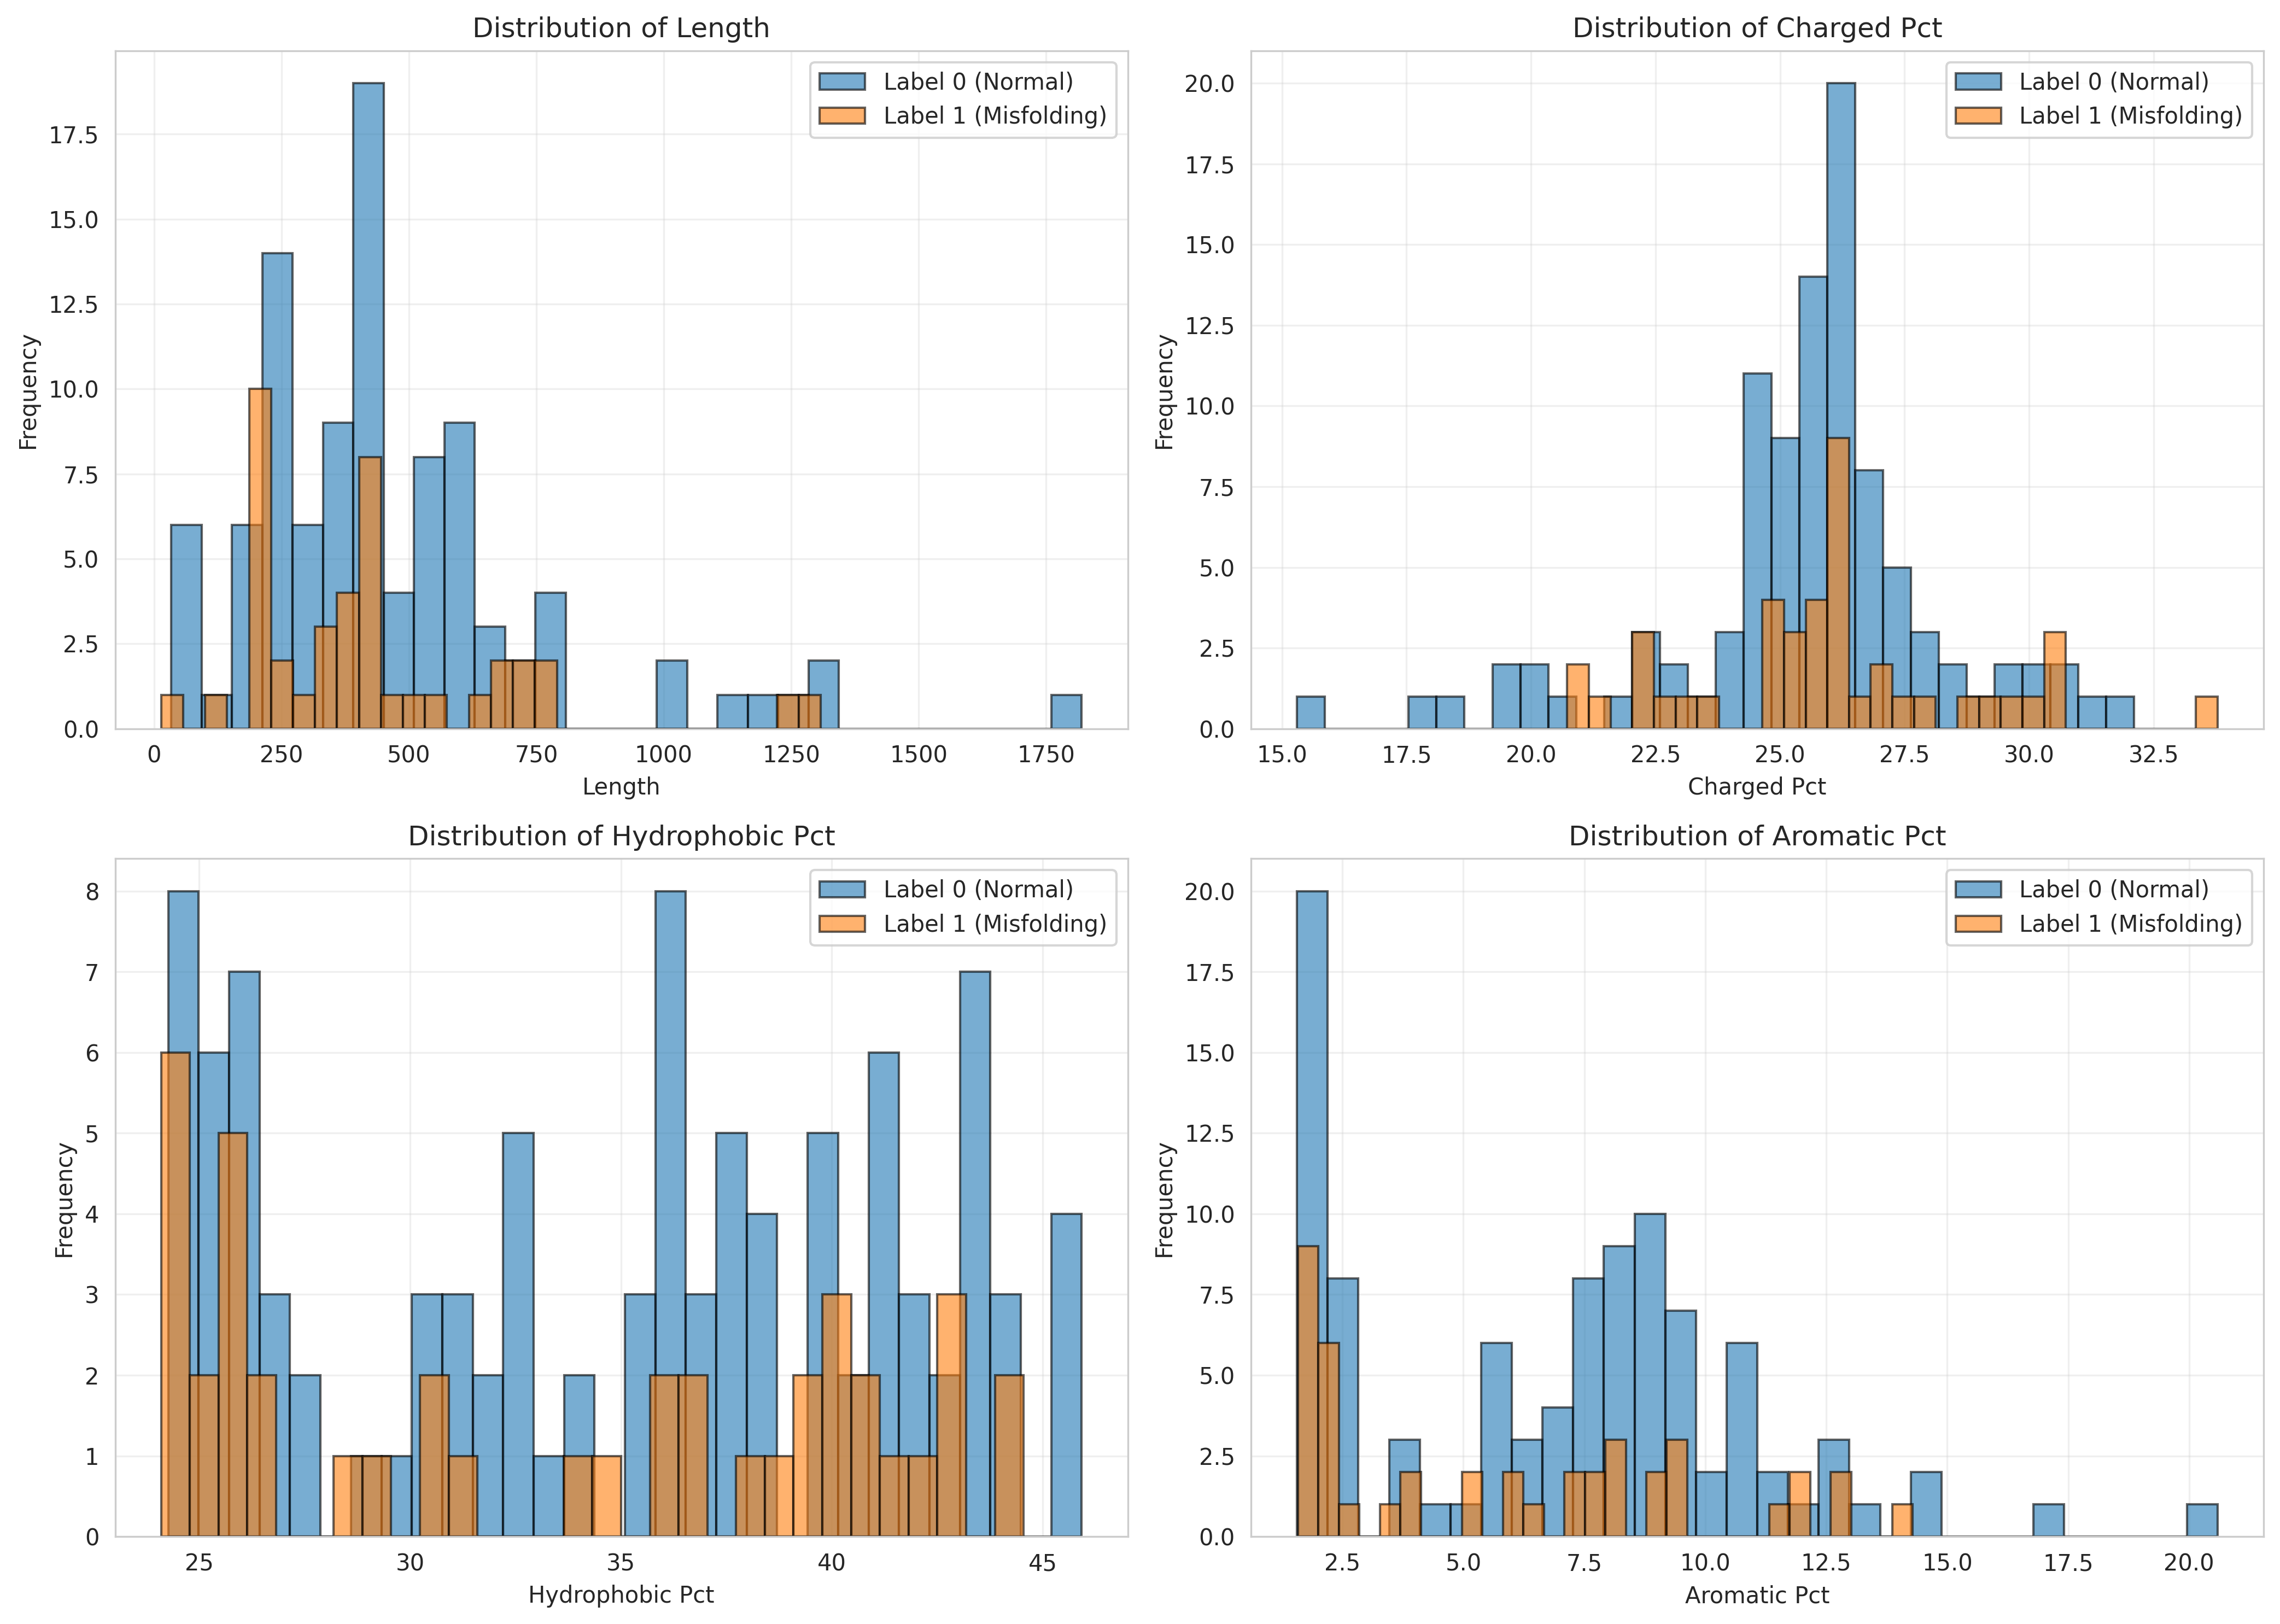


✅ Saved features to /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/results/embeddings


In [9]:
"""
Compute hand-crafted sequence features
These can be used alongside deep learning features
"""

print("=" * 80)
print("STEP 6: COMPUTING HAND-CRAFTED FEATURES")
print("=" * 80)

# Compute features for all splits
print("\n🔬 Computing features for all sequences...")

train_features = compute_sequence_features(train_sequences)
val_features = compute_sequence_features(val_sequences)
test_features = compute_sequence_features(test_sequences)

print(f"✅ Feature shapes:")
print(f"  Train: {train_features.shape}")
print(f"  Val:   {val_features.shape}")
print(f"  Test:  {test_features.shape}")

# Display feature statistics
print(f"\n📊 Training set feature statistics:")
print(train_features.describe())

# Visualize features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = ['length', 'charged_pct', 'hydrophobic_pct', 'aromatic_pct']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Plot by label
    train_data_with_label = train_data.copy()
    train_data_with_label[feature] = train_features[feature].values
    
    for label in [0, 1]:
        data = train_data_with_label[train_data_with_label['label'] == label][feature]
        ax.hist(data, bins=30, alpha=0.6, 
                label=f"Label {label} ({'Normal' if label == 0 else 'Misfolding'})",
                edgecolor='black')
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature.replace("_", " ").title()}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save features
train_features.to_csv(EMBEDDINGS_DIR / 'features_train.csv', index=False)
val_features.to_csv(EMBEDDINGS_DIR / 'features_val.csv', index=False)
test_features.to_csv(EMBEDDINGS_DIR / 'features_test.csv', index=False)

print(f"\n✅ Saved features to {EMBEDDINGS_DIR}")


In [10]:
"""
Save all preprocessed arrays and embeddings
"""

print("=" * 80)
print("STEP 7: SAVING PREPROCESSED DATA")
print("=" * 80)

# Save encoded sequences
print("\n💾 Saving encoded sequences...")
np.save(EMBEDDINGS_DIR / 'encoded_train.npy', train_encoded)
np.save(EMBEDDINGS_DIR / 'encoded_val.npy', val_encoded)
np.save(EMBEDDINGS_DIR / 'encoded_test.npy', test_encoded)

# Save attention masks
print("💾 Saving attention masks...")
np.save(EMBEDDINGS_DIR / 'masks_train.npy', train_masks)
np.save(EMBEDDINGS_DIR / 'masks_val.npy', val_masks)
np.save(EMBEDDINGS_DIR / 'masks_test.npy', test_masks)

# Save labels
print("💾 Saving labels...")
np.save(EMBEDDINGS_DIR / 'labels_train.npy', train_data['label'].values)
np.save(EMBEDDINGS_DIR / 'labels_val.npy', val_data['label'].values)
np.save(EMBEDDINGS_DIR / 'labels_test.npy', test_data['label'].values)

# Save protein IDs for reference
print("💾 Saving protein IDs...")
pd.Series(train_data['protein_id'].values).to_csv(EMBEDDINGS_DIR / 'protein_ids_train.csv', index=False, header=['protein_id'])
pd.Series(val_data['protein_id'].values).to_csv(EMBEDDINGS_DIR / 'protein_ids_val.csv', index=False, header=['protein_id'])
pd.Series(test_data['protein_id'].values).to_csv(EMBEDDINGS_DIR / 'protein_ids_test.csv', index=False, header=['protein_id'])

print("\n✅ All data saved successfully!")

# List all saved files
print(f"\n📁 Saved files in {EMBEDDINGS_DIR}:")
saved_files = sorted(EMBEDDINGS_DIR.glob('*'))
for f in saved_files:
    size_mb = f.stat().st_size / 1024**2
    print(f"  - {f.name} ({size_mb:.1f} MB)")


STEP 7: SAVING PREPROCESSED DATA

💾 Saving encoded sequences...
💾 Saving attention masks...
💾 Saving labels...
💾 Saving protein IDs...

✅ All data saved successfully!

📁 Saved files in /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/results/embeddings:
  - encoded_test.npy (0.1 MB)
  - encoded_train.npy (0.6 MB)
  - encoded_val.npy (0.1 MB)
  - features_test.csv (0.0 MB)
  - features_train.csv (0.0 MB)
  - features_val.csv (0.0 MB)
  - labels_test.npy (0.0 MB)
  - labels_train.npy (0.0 MB)
  - labels_val.npy (0.0 MB)
  - masks_test.npy (0.1 MB)
  - masks_train.npy (0.6 MB)
  - masks_val.npy (0.1 MB)
  - protbert_test.npy (0.1 MB)
  - protbert_train.npy (0.6 MB)
  - protbert_val.npy (0.1 MB)
  - protein_ids_test.csv (0.0 MB)
  - protein_ids_train.csv (0.0 MB)
  - protein_ids_val.csv (0.0 MB)


In [11]:
"""
Summary and next steps
"""

print("=" * 80)
print("✅ PREPROCESSING COMPLETE!")
print("=" * 80)

print("\n📊 Dataset Summary:")
print(f"  Train samples: {len(train_data)}")
print(f"  Val samples: {len(val_data)}")
print(f"  Test samples: {len(test_data)}")
print(f"  Total samples: {len(df_with_splits)}")

print("\n📦 Generated Data:")
print("  1. ProtBERT embeddings (1024-dim)")
print("  2. Integer-encoded sequences")
print("  3. Attention masks")
print("  4. Hand-crafted features")
print("  5. Labels")

print("\n💾 Storage Summary:")
total_size = sum(f.stat().st_size for f in EMBEDDINGS_DIR.glob('*'))
print(f"  Total preprocessed data: {total_size / 1024**2:.1f} MB")

print("\n🎯 Next Steps:")
print("  → Run notebook 03_training.ipynb to:")
print("     - Train Model A (ProtBERT + SVM)")
print("     - Train Model B (ProtBERT Fine-tune)")
print("     - Train Model C (CNN-BiLSTM)")
print("     - Train Model D (Lite Transformer)")
print("     - Generate predictions for stacking")

print("\n" + "=" * 80)


✅ PREPROCESSING COMPLETE!

📊 Dataset Summary:
  Train samples: 141
  Val samples: 31
  Test samples: 31
  Total samples: 203

📦 Generated Data:
  1. ProtBERT embeddings (1024-dim)
  2. Integer-encoded sequences
  3. Attention masks
  4. Hand-crafted features
  5. Labels

💾 Storage Summary:
  Total preprocessed data: 2.6 MB

🎯 Next Steps:
  → Run notebook 03_training.ipynb to:
     - Train Model A (ProtBERT + SVM)
     - Train Model B (ProtBERT Fine-tune)
     - Train Model C (CNN-BiLSTM)
     - Train Model D (Lite Transformer)
     - Generate predictions for stacking

